<a href="https://www.kaggle.com/code/brmil07/binary-classification-with-a-bank-churn-dataset?scriptVersionId=160900539" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Binary Classification with a Bank Churn Dataset**
---

This is my notebook for submission to the 2024 Kaggle Playground Series. This is the 1st episode of Season 4 and the goal of this episode is to predict whether a customer continues with their account or closes it (e.g., churns).

## **Dataset Description**
The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

* Customer ID: A unique identifier for each customer
* Surname: The customer's surname or last name
* Credit Score: A numerical value representing the customer's credit score
* Geography: The country where the customer resides (France, Spain or Germany)
* Gender: The customer's gender (Male or Female)
* Age: The customer's age.
* Tenure: The number of years the customer has been with the bank
* Balance: The customer's account balance
* NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
* HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
* IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
* EstimatedSalary: The estimated salary of the customer
* Exited: Whether the customer has churned (1 = yes, 0 = no)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil
from tqdm import tqdm

from sklearn.base import is_classifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Load your dataset
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

# **Exploratory Data Analysis**
---

In [3]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
train_df.set_index('id', inplace=True)

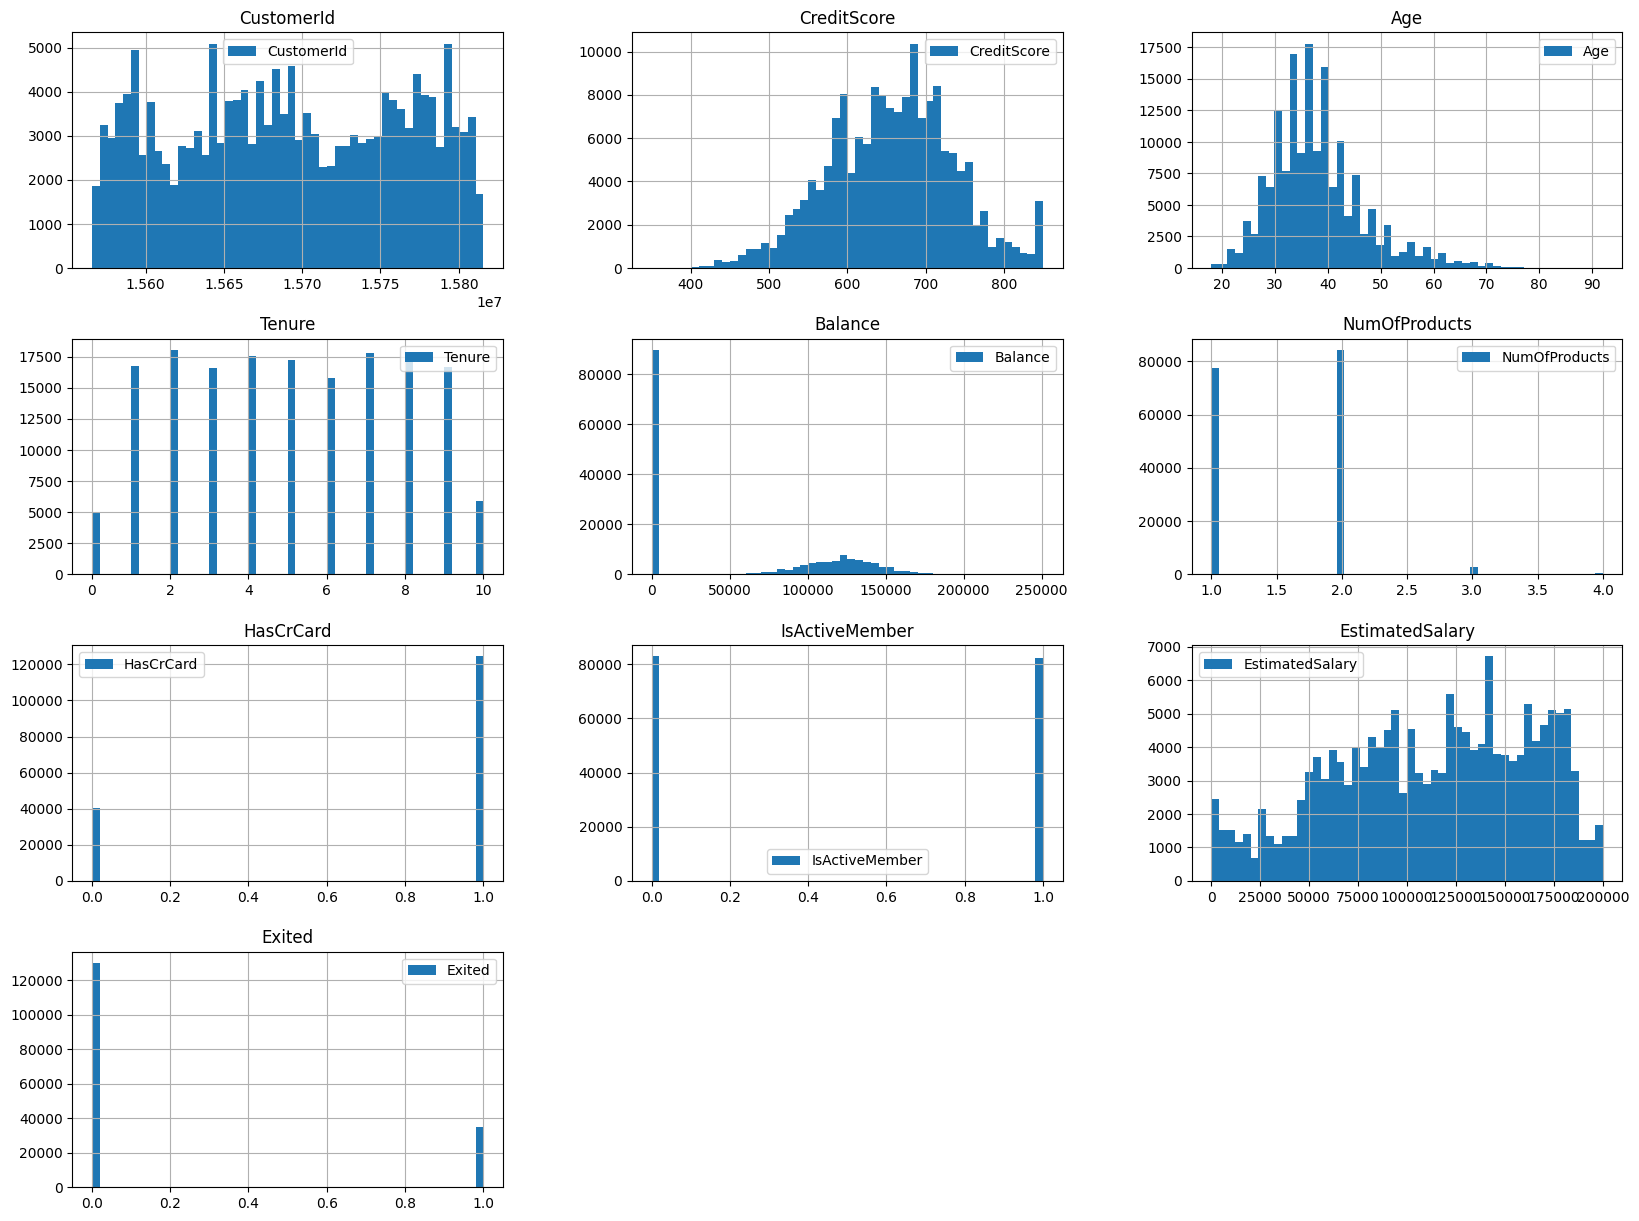

In [5]:
train_df.hist(bins=50, figsize=(20,15), legend = True)
plt.show()

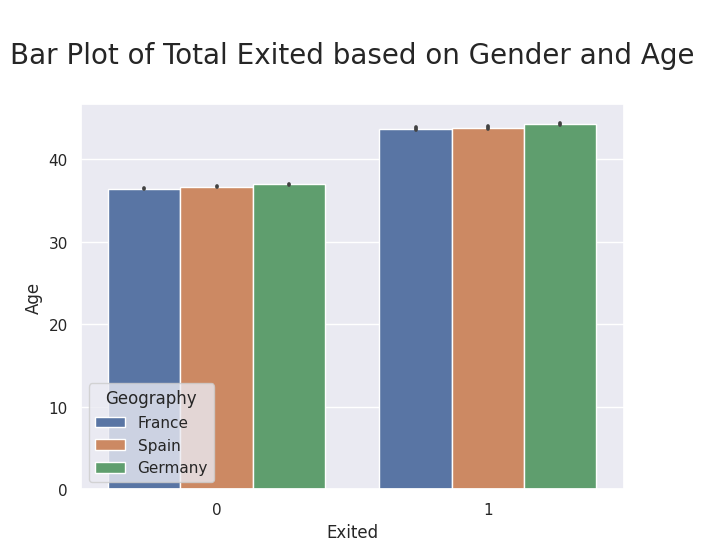

In [6]:
sns.set(rc={'figure.figsize':(7,5)})
ax=sns.barplot(data=train_df,x='Exited',y='Age',hue='Geography')
ax.axes.set_title("\nBar Plot of Total Exited based on Gender and Age\n",fontsize=20);

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [8]:
# Check for duplicates
train_df.duplicated().sum()

0

In [9]:
# Check for missing values
train_df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Return the number of unique values for each column
train_df.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

In [11]:
# Return a series that contains the number of unique values
train_df["Exited"].value_counts(ascending=True)

Exited
1     34921
0    130113
Name: count, dtype: int64

In [12]:
train_df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [13]:
t_df=train_df[['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']]

In [14]:
labelencoder = LabelEncoder()
for col in t_df.columns:
    if t_df[col].dtypes == 'object':
        t_df.loc[:, col] = labelencoder.fit_transform(t_df[col])
        
t_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
0,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83
...,...,...,...,...,...,...,...,...,...,...
165029,667,2,0,33.0,2,0.00,1,1.0,1.0,131834.75
165030,792,0,1,35.0,3,0.00,1,0.0,0.0,131834.45
165031,565,0,1,31.0,5,0.00,1,1.0,1.0,127429.56


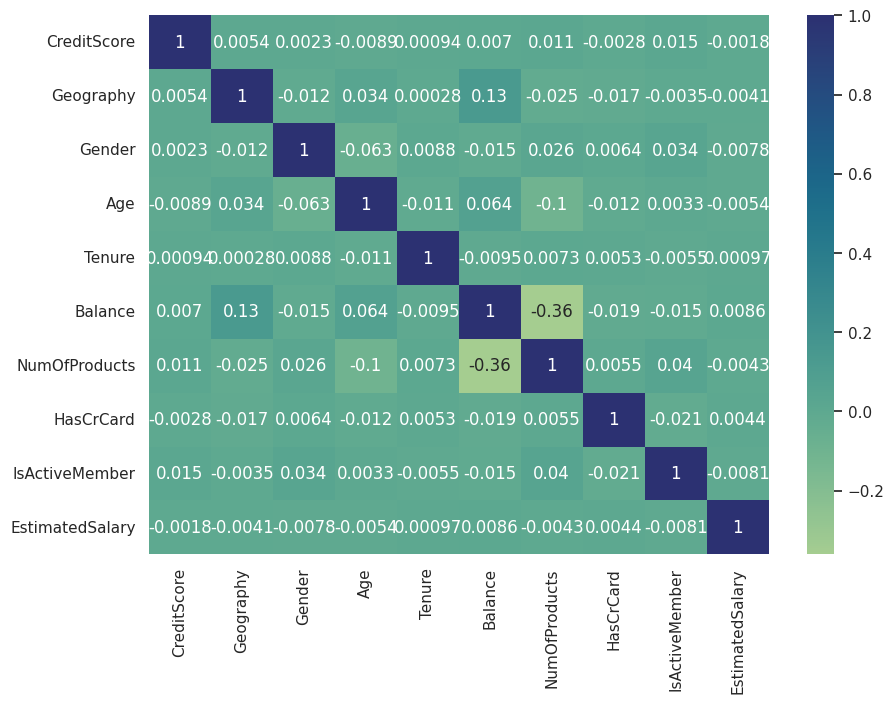

In [15]:
corr = t_df.corr()
# plot the heatmap
plt.figure(figsize=(10, 7))
s=sns.heatmap(corr,annot=True, cmap='crest')

# **Data Prepocessing**
---

In [16]:
# Column 'Exited' is the target variable
X = train_df.drop(['CustomerId', 'Surname', 'Exited'], axis=1)  # Exclude irrelevant columns
y = train_df['Exited']

# Identifying categorical features
categorical_features = ['Geography', 'Gender']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Creating transformers for numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = StandardScaler()

# Pipeline for transforming categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

# **Build the Model**
---

In [18]:
# Define classifiers and their corresponding names
classifiers = {
    'LightGBM': LGBMClassifier(n_estimators=1000, learning_rate=0.03, max_depth=8, min_child_samples=8, 
                               subsample=0.75, colsample_bytree=0.5, random_state=42),
    'CatBoost': CatBoostClassifier(iterations=800, learning_rate=0.07, depth=5,
                                   l2_leaf_reg=0.8, random_state=42, verbose=0),
    'XGBoost': XGBClassifier(n_estimators=800, learning_rate=0.07, max_depth=5,
                             min_child_weight=8, gamma=0.27, n_jobs=-1,random_state=42),
    'Logistic Regression': CalibratedClassifierCV(LogisticRegression(random_state=42), method='sigmoid'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=2),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100,random_state=0),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    'AdaBoostClassifier': AdaBoostClassifier()
}

performance_list = []

Training models: 100%|██████████| 11/11 [03:49<00:00, 20.87s/model]


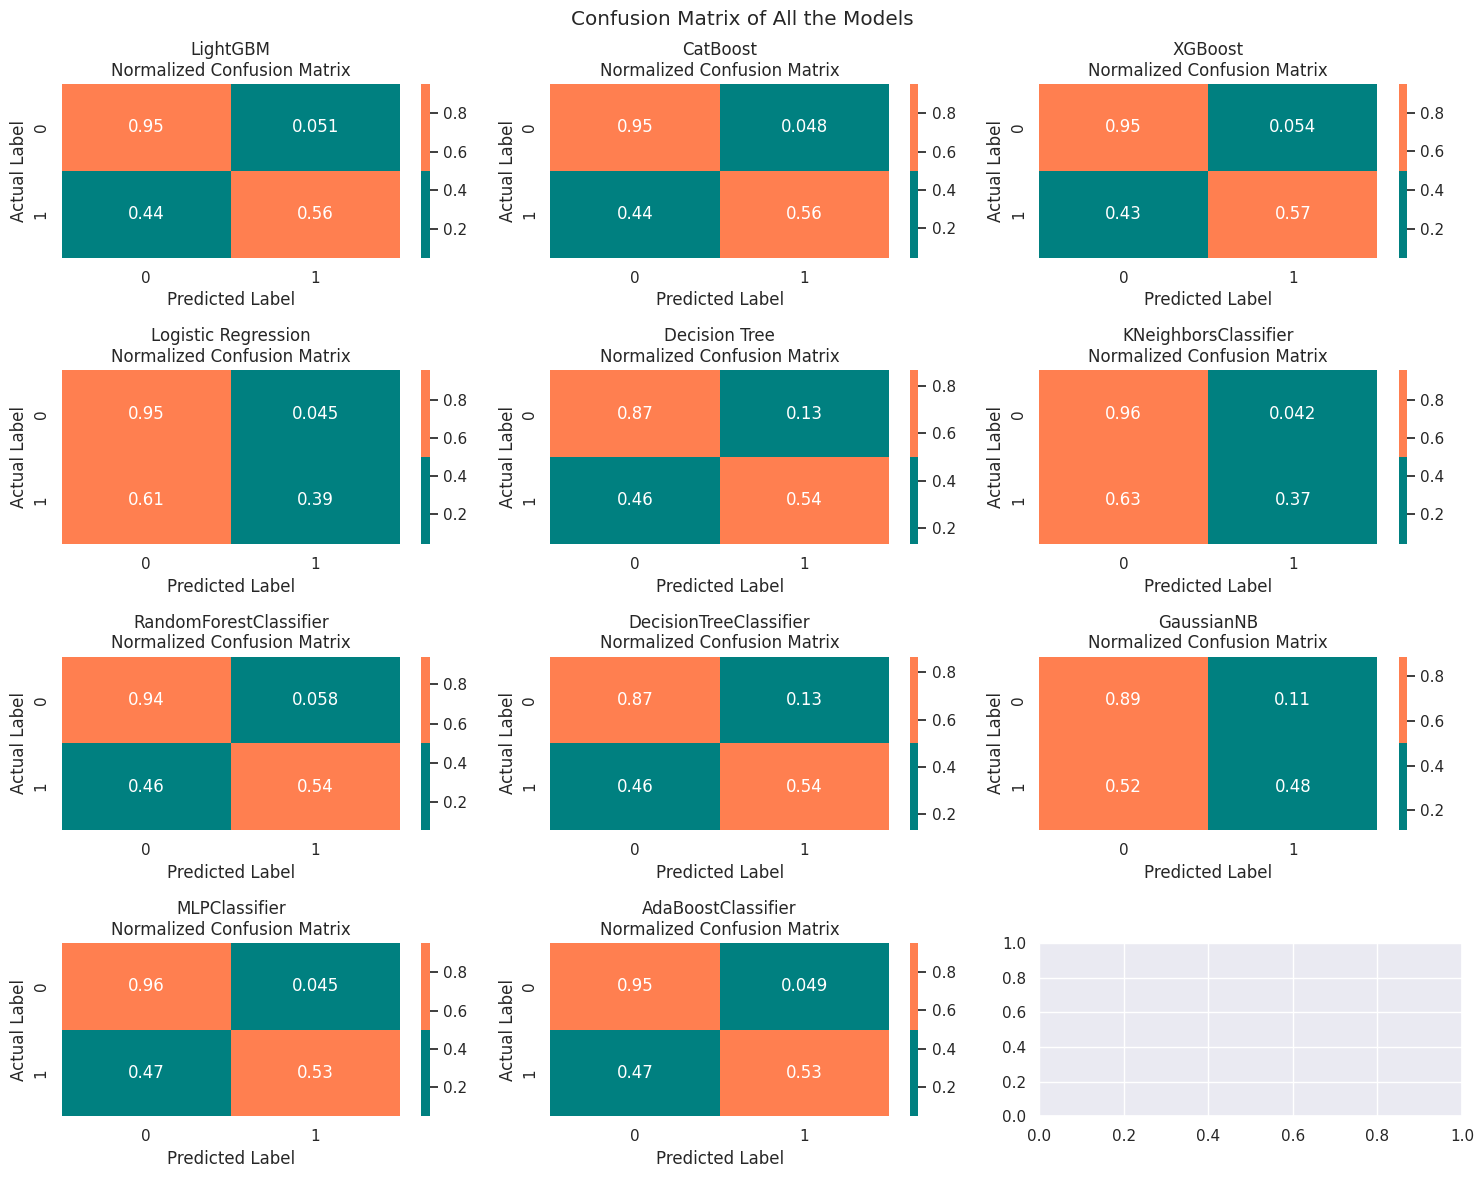

In [19]:
# Train and evaluate models
num_rows = 4
num_columns = ceil(len(classifiers) / num_rows)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 12))

# Train and evaluate models
for name, classifier in tqdm(classifiers.items(), desc='Training models', unit='model'):
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', classifier)])
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)
    test_probabilities = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, test_predictions)
    conf_matrix = confusion_matrix(y_test, test_predictions, normalize='true')
    classification_rep = classification_report(y_test, test_predictions)
    roc_auc = roc_auc_score(y_test, test_probabilities)
    
    performance_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': conf_matrix,
        'Classification Report': classification_rep
    })
    
    # Plot the confusion matrix
    idx = list(classifiers.keys()).index(name)
    row_idx = idx // num_columns
    col_idx = idx % num_columns
    
    sns.heatmap(conf_matrix, annot=True, cmap=['teal', 'coral'], ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'{name}\nNormalized Confusion Matrix')
    axes[row_idx, col_idx].set_xlabel('Predicted Label')
    axes[row_idx, col_idx].set_ylabel('Actual Label')

plt.suptitle('Confusion Matrix of All the Models')
plt.tight_layout()
plt.show()

# **Create Voting Classifier**
---
A Voting Classifier is an ensemble learning technique in machine learning that combines numerous separate models to increase the model's overall prediction performance and generalizability. It operates by combining predictions from different base models and creating a final forecast based on either a majority vote (hard voting) or a weighted average of anticipated probabilities (soft voting).

In [20]:
# Create a VotingClassifier
voting_classifier = VotingClassifier(estimators=list(classifiers.items()), voting='soft')
voting_classifier

VotingClassifier(estimators=[('LightGBM',
                              LGBMClassifier(colsample_bytree=0.5,
                                             learning_rate=0.03, max_depth=8,
                                             min_child_samples=8,
                                             n_estimators=1000, random_state=42,
                                             subsample=0.75)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7bbbd7161a20>),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample...
                              DecisionTreeClassifier(random_state=42)),
                             ('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=2)),
                             ('RandomForestClassifier',
                              RandomForestClassifier(random_state=0)),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier(random_state=42)),
                             ('GaussianNB', GaussianNB()),
                             ('MLPClassifier', MLPClassifier(max_iter=1000)),
                             ('AdaBoostClassifier', AdaBoostClassifier())],
                 voting='soft')

In [21]:
# Train and evaluate the VotingClassifier
voting_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_classifier)])
voting_model.fit(X_train, y_train)

voting_test_predictions = voting_model.predict(X_test)
voting_test_probabilities = voting_model.predict_proba(X_test)[:, 1]

voting_accuracy = accuracy_score(y_test, voting_test_predictions)
voting_conf_matrix = confusion_matrix(y_test, voting_test_predictions)
voting_classification_rep = classification_report(y_test, voting_test_predictions)
voting_roc_auc = roc_auc_score(y_test, voting_test_probabilities)

print('Voting Classifier:')
print(f'Voting Classifier - Accuracy on validation set: {voting_accuracy:.2f}')
print(f'Voting Classifier - ROC-AUC on validation set: {voting_roc_auc:.2f}')
print(f'Voting Classifier - Confusion Matrix:\n{np.array2string(voting_conf_matrix, precision=2)}')
print(f'Voting Classifier - Classification Report:\n{voting_classification_rep}')

performance_list.append({
    'Model': 'Voting Classifier',
    'Accuracy': voting_accuracy,
    'ROC-AUC': voting_roc_auc,
    'Confusion Matrix': voting_conf_matrix,
    'Classification Report': voting_classification_rep
})

Voting Classifier:
Voting Classifier - Accuracy on validation set: 0.86
Voting Classifier - ROC-AUC on validation set: 0.88
Voting Classifier - Confusion Matrix:
[[24571  1481]
 [ 3237  3718]]
Voting Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26052
           1       0.72      0.53      0.61      6955

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



# **Model Evaluation**
---

In [22]:
performance_df = pd.DataFrame(performance_list)

# Use rank() to create a new column 'rank'
performance_df['Rank'] = performance_df['ROC-AUC'].rank(ascending=False, method='first').astype(int)
# Sort the DataFrame by the 'rank' column in ascending order
performance_df = performance_df.sort_values(by='Rank')
# Get the first row (with the lowest rank)
best_model_performance = performance_df.iloc[0]['Model']

performance_df.style.background_gradient(cmap='viridis')

,Model,Accuracy,ROC-AUC,Confusion Matrix,Classification Report,Rank
0,LightGBM,0.867877,0.891738,[[0.9488331 0.0511669 ] [0.43537024 0.56462976]],precision recall f1-score support 0 0.89 0.95 0.92 26052 1 0.75 0.56 0.64 6955 accuracy 0.87 33007 macro avg 0.82 0.76 0.78 33007 weighted avg 0.86 0.87 0.86 33007,1
1,CatBoost,0.868695,0.891365,[[0.95224935 0.04775065] [0.44428469 0.55571531]],precision recall f1-score support 0 0.89 0.95 0.92 26052 1 0.76 0.56 0.64 6955 accuracy 0.87 33007 macro avg 0.82 0.75 0.78 33007 weighted avg 0.86 0.87 0.86 33007,2
2,XGBoost,0.866968,0.891235,[[0.94649163 0.05350837] [0.43091301 0.56908699]],precision recall f1-score support 0 0.89 0.95 0.92 26052 1 0.74 0.57 0.64 6955 accuracy 0.87 33007 macro avg 0.82 0.76 0.78 33007 weighted avg 0.86 0.87 0.86 33007,3
9,MLPClassifier,0.864665,0.888508,[[0.95516659 0.04483341] [0.47433501 0.52566499]],precision recall f1-score support 0 0.88 0.96 0.92 26052 1 0.76 0.53 0.62 6955 accuracy 0.86 33007 macro avg 0.82 0.74 0.77 33007 weighted avg 0.86 0.86 0.86 33007,4
10,AdaBoostClassifier,0.863059,0.881626,[[0.95121296 0.04878704] [0.46714594 0.53285406]],precision recall f1-score support 0 0.88 0.95 0.92 26052 1 0.74 0.53 0.62 6955 accuracy 0.86 33007 macro avg 0.81 0.74 0.77 33007 weighted avg 0.85 0.86 0.85 33007,5
11,Voting Classifier,0.857061,0.878848,[[24571 1481] [ 3237 3718]],precision recall f1-score support 0 0.88 0.94 0.91 26052 1 0.72 0.53 0.61 6955 accuracy 0.86 33007 macro avg 0.80 0.74 0.76 33007 weighted avg 0.85 0.86 0.85 33007,6
6,RandomForestClassifier,0.856394,0.873517,[[0.94157838 0.05842162] [0.46268871 0.53731129]],precision recall f1-score support 0 0.88 0.94 0.91 26052 1 0.71 0.54 0.61 6955 accuracy 0.86 33007 macro avg 0.80 0.74 0.76 33007 weighted avg 0.85 0.86 0.85 33007,7
3,Logistic Regression,0.835429,0.818049,[[0.95485951 0.04514049] [0.61193386 0.38806614]],precision recall f1-score support 0 0.85 0.95 0.90 26052 1 0.70 0.39 0.50 6955 accuracy 0.84 33007 macro avg 0.78 0.67 0.70 33007 weighted avg 0.82 0.84 0.82 33007,8
8,GaussianNB,0.801042,0.813704,[[0.88714878 0.11285122] [0.52149533 0.47850467]],precision recall f1-score support 0 0.86 0.89 0.88 26052 1 0.53 0.48 0.50 6955 accuracy 0.80 33007 macro avg 0.70 0.68 0.69 33007 weighted avg 0.79 0.80 0.80 33007,9
5,KNeighborsClassifier,0.833853,0.769382,[[0.95754645 0.04245355] [0.6294752 0.3705248 ]],precision recall f1-score support 0 0.85 0.96 0.90 26052 1 0.70 0.37 0.48 6955 accuracy 0.83 33007 macro avg 0.78 0.66 0.69 33007 weighted avg 0.82 0.83 0.81 33007,10


In [23]:
print(best_model_performance)

LightGBM


In [24]:
# Choose the best model for this dataset
best_model = classifiers[best_model_performance]

# Train the best model on the entire training dataset
final_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_model)])
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03,
                                max_depth=8, min_child_samples=8,
                                n_estimators=1000, random_state=42,
                                subsample=0.75))])

In [25]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# Display cross-validated scores
print('Cross-validated MAE scores:', -cv_scores)
print('Mean Cross-validated MAE:', -cv_scores.mean())

Cross-validated MAE scores: [0.13621904 0.13659774 0.13364893 0.13292937 0.13425488]
Mean Cross-validated MAE: 0.13472999191983287


# **Submit the Prediction**
---

In [26]:
test_probabilities = final_model.predict_proba(test_df)[:, 1]

In [27]:
# Create a submission DataFrame
submission = pd.DataFrame({'id': test_df['id'], 'Exited': test_probabilities})

# Save the submission file
submission.to_csv('submission.csv', index=False)

In [28]:
submission

,id,Exited
0,165034,0.024122
1,165035,0.823747
2,165036,0.025215
3,165037,0.221648
4,165038,0.359235
...,...,...
110018,275052,0.032352
110019,275053,0.137836
110020,275054,0.017464
110021,275055,0.145419


# **References**
---
* [Kaggle Competition Playground Series Season 4 Episode 1](https://www.kaggle.com/competitions/playground-series-s4e1)
* [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction)